<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>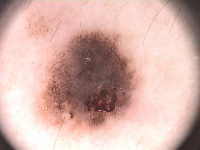</td><td>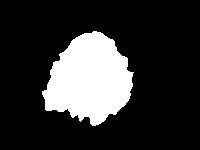</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [29]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=4dae6f71-7efc-441a-9e4d-fbb9dd855a53
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 154MB/s]


In [30]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [31]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [32]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [33]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

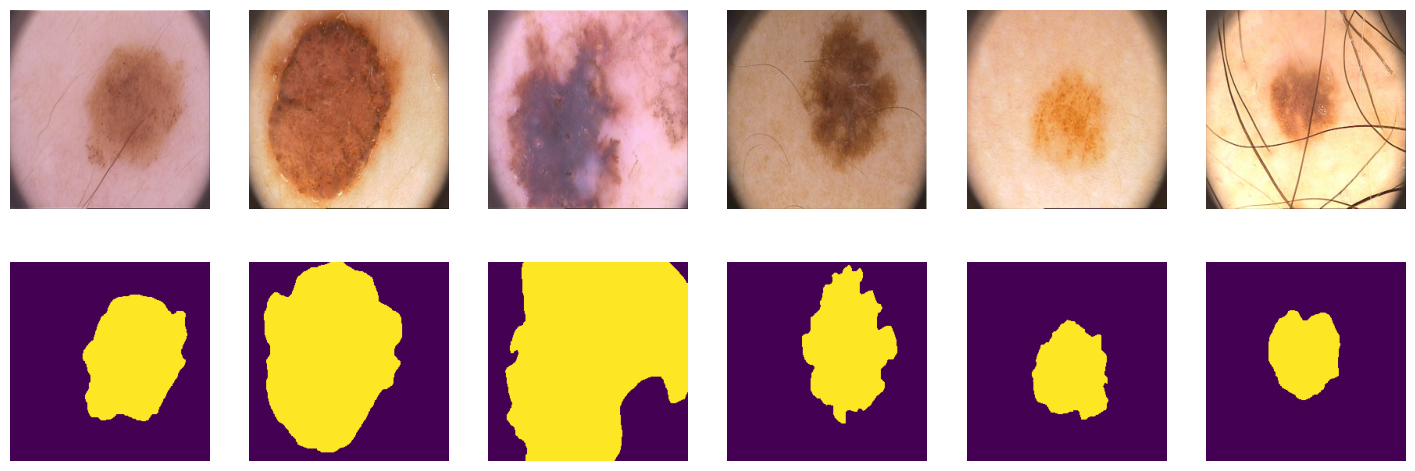

In [34]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [35]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [36]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [37]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [38]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [39]:
!pip install torchmetrics

ERROR: Operation cancelled by user


In [40]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** \\
$$\mathcal
y * -log(sigmoid(\hat y\ )) + (1 - y) * -log(1 - sigmoid(\hat y\ )) \\
= y * -log(1 / (1 + exp(-\hat y\ ))) + (1 - y) * -log(exp(-\hat y\ ) / (1 + exp(-\hat y\ ))) \\
= y * log(1 + exp(-\hat y\ )) + (1 - y) * (-log(exp(-\hat y\ )) + log(1 + exp(-\hat y\ ))) \\
= y * log(1 + exp(-\hat y\ )) + (1 - y) * (\hat y\  + log(1 + exp(-\hat y\ ))) \\
= (1 - y) * \hat y\  + log(1 + exp(-\hat y\ )) \\
= \hat y\ - \hat y\  * y + log(1 + exp(-\hat y\ )) $$


### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [41]:
import torch.nn.functional as F
import torch.nn as nn

In [42]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [136]:
def bce_loss(y_pred, y_real):
  return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum()
def bce_true(y_pred, y_real):
  return -(y_real * torch.log(y_pred.sigmoid()) + (1 - y_real) * torch.log(1 - y_pred.sigmoid())).sum()


Проверим корректность работы на простом примере

In [44]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.054800510406494
BCE loss честно посчитанный = 5.0548014640808105
BCE loss from torch bce_torch = 5.054800510406494
BCE loss from torch with logits bce_torch = 5.054800510406494


<ipython-input-43-3d144e2fc536>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -(y_real * np.log(F.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - F.sigmoid(y_pred))).sum()
<ipython-input-43-3d144e2fc536>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))).sum()


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [45]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

<ipython-input-43-3d144e2fc536>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -(y_real * np.log(F.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - F.sigmoid(y_pred))).sum()
<ipython-input-43-3d144e2fc536>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))).sum()


Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [46]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 18.492046356201172
BCE loss честно посчитанный = 18.49204444885254
BCE loss from torch bce_torch = 18.492046356201172
BCE loss from torch with logits bce_torch = 18.492046356201172


<ipython-input-43-3d144e2fc536>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -(y_real * np.log(F.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - F.sigmoid(y_pred))).sum()
<ipython-input-43-3d144e2fc536>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))).sum()


In [47]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

<ipython-input-43-3d144e2fc536>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -(y_real * np.log(F.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - F.sigmoid(y_pred))).sum()
<ipython-input-43-3d144e2fc536>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))).sum()


Давайте посчитаем на реальных логитах и сегментационной маске:

In [48]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.05MB/s]
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gdown/__main__.py", line 158, in main
  File "/usr/local/lib/python3.11/dist-packages/gdown/download_folder.py", line 325, in download_folder
    local_path = download(
                 ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/l

In [49]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

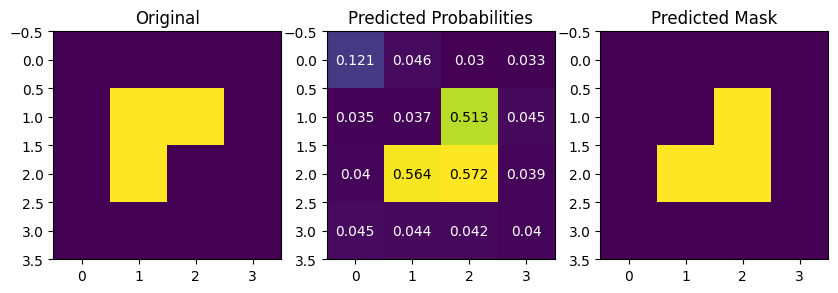

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [51]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

<ipython-input-43-3d144e2fc536>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -(y_real * np.log(F.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - F.sigmoid(y_pred))).sum()
<ipython-input-43-3d144e2fc536>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))).sum()


## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

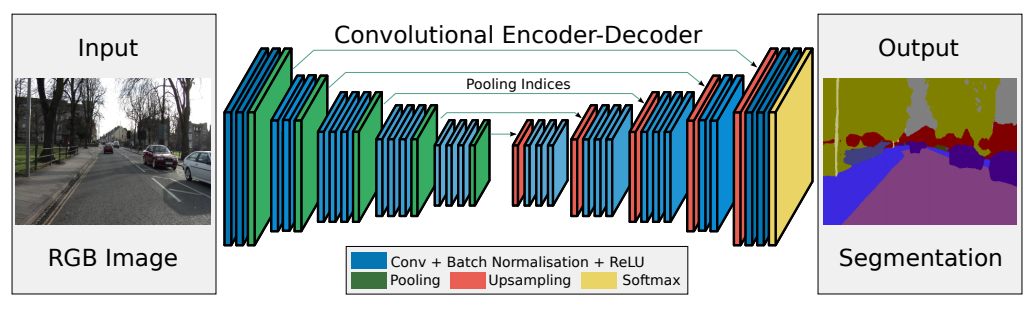

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [53]:
import torch
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        # Decoder
        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=4, kernel_size=3, stride=1, padding=1)
        )


    def forward(self, x):
        # Encoder
        size1_pre = x.size()
        x = self.conv1(x)
        x, idxs1 = self.pool1(x)

        size2_pre = x.size()
        x = self.conv2(x)
        x, idxs2 = self.pool2(x)

        size3_pre = x.size()
        x = self.conv3(x)
        x, idxs3 = self.pool3(x)

        size4_pre = x.size()
        x = self.conv4(x)
        x, idxs4 = self.pool4(x)

        size5_pre = x.size()
        x = self.conv5(x)
        x, idxs5 = self.pool5(x)

        # Decoder
        x = self.unpool5(x, idxs5, output_size=size5_pre)
        x = self.dec_conv5(x)

        x = self.unpool4(x, idxs4, output_size=size4_pre)
        x = self.dec_conv4(x)

        x = self.unpool3(x, idxs3, output_size=size3_pre)
        x = self.dec_conv3(x)

        x = self.unpool2(x, idxs2, output_size=size2_pre)
        x = self.dec_conv2(x)

        x = self.unpool1(x, idxs1, output_size=size1_pre)
        x = self.dec_conv1(x)

        output = x
        return output

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [55]:
from tqdm.notebook import tqdm

In [56]:
ckpt_path = '/content/checkpoints'

In [57]:
def train(train_dataloader, val_dataloader, model, optimizer, criterion, num_epoch):
    train_loss = []
    val_loss = []
    val_iou = []
    train_dataloader, val_dataloader = train_dataloader.to(device), val_dataloader.to(device)
    best_val_loss = float('inf')
    for epoch in tqdm(range(num_epoch)):
        avg_train_loss = 0
        model.train()
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)
            cur_train_loss = criterion(logits, y_batch)
            cur_train_loss.backward()
            optimizer.step()

            avg_train_loss += cur_train_loss

        avg_val_loss = 0
        avg_val_iou = 0
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                logits = model(x_batch)
                cur_val_loss = criterion(logits, y_batch)
                cur_val_iou = JaccardIndex(logits, y_batch)

                avg_val_loss += cur_val_loss
                avg_val_iou += cur_val_iou

        train_loss.append(avg_train_loss/len(train_dataloader))
        val_loss.append(avg_val_loss/len(val_dataloader))
        val_iou.append(avg_val_iou/len(val_dataloader))

        if avg_val_loss/len(val_dataloader) < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

        print(f'Epoch {epoch}: train loss = {avg_train_loss/len(train_dataloader)}')
        print(f'Epoch {epoch}: val loss = {avg_val_loss/len(val_dataloader)}')
        print(f'Epoch {epoch}: val iou = {avg_val_iou/len(val_dataloader)}')

        statistics = {'train loss': train_loss,
                  'val_loss': val_loss,
                  'val_iou': val_iou}

        return model, statistics


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

**ЗАГРУЗИМ ДАТАСЕТ С СЕМИНАРА**

In [58]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [59]:
class SelfDrivingDataset(Dataset):
    def __init__(self, images, segmentation_masks):

        self.images = images
        self.segmentation_masks = segmentation_masks

        self.images_transforms = transforms.Compose([
            transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        ])

        self.masks_transforms = transforms.Compose([
            # используем InterpolationMode.NEAREST, чтобы при изменении размера
            # маски сегментации не менялись номера классов
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        ])

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-сегментация (index)
        возвращать эту пару. Этот метод обязательно нужно реализовывать во всех
        кастомных классах Dataset. Перед тем, как выдать на выходе
        пару картинка-сегментация, можно применить к картинкам любые преобразования:
        например, знакомую нам аугментацию.
        '''

        # загружаем нужные картинку и ее карту сегментации
        img = Image.open(self.images[index])
        mask = Image.open(self.segmentation_masks[index])

        # # применяем предобработку к RGB картинке
        img = self.images_transforms(img)
        # # применяем предобработку к маске сегментации
        mask = self.masks_transforms(mask)*255

        # # делим маску сегментации на 13 бинарных масок сегментации
        # # отдельно для каждого класса
        masks = []

        # вытаскиваем пиксели, принадлежащие классам unlabeled, building, road и car.
        for i in [0, 1, 7, 10]:
            # генерируем бинарную маску сегментации для текущего класса i
            cls_mask = torch.where(mask==i, 1, 0)
            masks.append(cls_mask[0,:,:].numpy())

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        # схлопываем бинарные карты сегментации в одну
        masks = torch.argmax(masks, axis=0)

        # возвращаем пару: картинка — ее маска сегментации на 4 класса
        return (img, masks)

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-сегментация в датасете
        '''
        return len(self.images)

In [60]:
# !pip install wldhx.yadisk-direct

In [61]:
# !curl -L $(yadisk-direct https://disk.yandex.com/d/jJrOLbYlBYVESQ) -o lyft_segmentation.zip

In [62]:
# !unzip lyft_segmentation.zip

In [63]:
# images = []
# segmentation_masks = []

# for img_name in os.listdir('./lyft_segmentation/images/'):
#     images.append('./lyft_segmentation/images/' + img_name)

# for img_name in os.listdir('./lyft_segmentation/segmentation_masks/'):
#     segmentation_masks.append('./lyft_segmentation/segmentation_masks/' + img_name)

# labels_used = ['Unlabeled', 'Building', 'Road', 'Car']

# dataset = SelfDrivingDataset(images, segmentation_masks)

# # dataset[0] — это вызов метода __getitem__(0)
# img, mask = dataset[3]

# train_size = int(len(dataset) * 0.8)
# val_size = len(dataset) - train_size

# train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

# train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: './lyft_segmentation/images/'

In [ ]:
#segnet_model_bce = SegNet().to(device)
# opt = torch.optim.AdamW(segnet_model.parameters(), lr=3e-4)
# criterion = bce_loss()
# train(train_dataloader, val_dataloader, segnet_model_bce, opt, criterion, 10)

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(test_dataloader, model, ckpt_path):
    test_dataloader = test_dataloader.to(device)
    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}')).to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0

    with torch.no_grad():
        for x_batch, y_batch in test_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)
            avg_iou += iou_score(logits, y_batch)

    return avg_iou/len(test_dataloader)

In [ ]:
test(val_dataloader, segnet_model, ckpt_path)

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [105]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob = logits.sigmoid()
    preds = (prob > threshold).float()
    tp = torch.sum(preds*labels)
    fp = torch.sum(preds) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    score = (2 * tp + eps) / (2 * tp + fn + fp + eps)
    return score

Проверим на корректность функцию dice_score:

In [111]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1).to(device)
dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int())
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.6667, device='cuda:0')

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

In [112]:
assert dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int()) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [113]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''

    '''
    prob = logits.sigmoid()
    tp = torch.sum(prob*labels)
    fp = torch.sum(prob) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    score = (2 * tp + eps) / (2 * tp + fn + fp + eps)
    loss = 1 - score

    return loss

Проверка на корректность:

In [115]:
#проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00


In [116]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [117]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [150]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    prob = y_pred.sigmoid()
    loss = - torch.sum((1 - (prob * y_real + (1 - prob) * (1 - y_real))) ** gamma  * (y_real * torch.log(prob) + (1 - y_real) * torch.log(1 - prob)))

    return loss

Проверка корректности функции:

In [151]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2)

tensor(3.6161, device='cuda:0')

In [154]:
assert np.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').to('cpu'),  focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0).to('cpu'))

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [156]:
def tversky_loss(logits, labels, alpha=0.5, betta=0.5):

    prob = logits.sigmoid()
    tp = torch.sum(prob*labels)
    fp = torch.sum(prob) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    loss = (tp + eps) / (tp + alpha*fp + betta*fn + eps)
    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
# opt = torch.optim.AdamW(segnet_model.parameters(), lr=3e-4)
segnet_model_dice = SegNet().to(device)
# dice = dice_loss()
# train(train_dataloader, val_dataloader, segnet_model_dice, opt, dice, 10)
segnet_model_focal = SegNet().to(device)
# focal = focal_loss()
# train(train_dataloader, val_dataloader, segnet_model_focal, opt, focal, 10)
segnet_model_tversky = SegNet().to(device)
# tversky = tversky_loss()
# train(train_dataloader, val_dataloader, segnet_model_tversky, opt, tversky, 10)

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

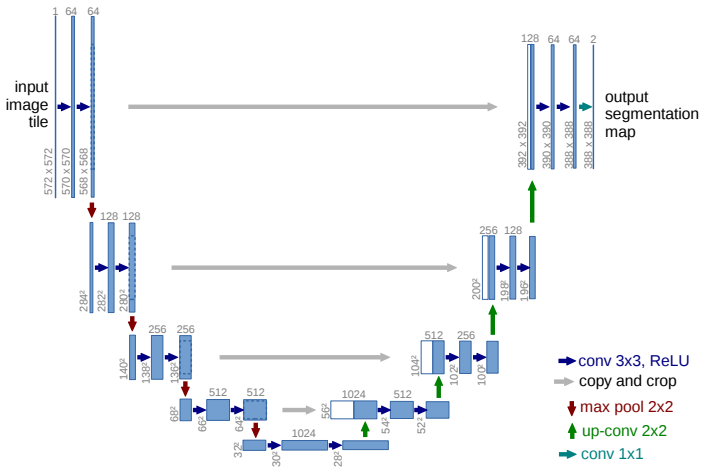

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [162]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

        self.up_trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.up_trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.up_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.up_trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(64, n_class, kernel_size=1)

    def _concat_skip(self, upsampled, skip_connection):
        # Иногда из-за пулинга/транспонированной свертки размеры могут отличаться на 1 пиксель
        diffY = skip_connection.size()[2] - upsampled.size()[2]
        diffX = skip_connection.size()[3] - upsampled.size()[3]

        # Дополняем (pad) тензор после апсемплинга, чтобы размеры совпали
        # Паддинг: (слева, справа, сверху, снизу)
        upsampled = F.pad(upsampled, [diffX // 2, diffX - diffX // 2,
                                      diffY // 2, diffY - diffY // 2])

        # Конкатенируем по оси каналов (dim=1)
        return torch.cat([skip_connection, upsampled], dim=1)

    def forward(self, x):

        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        bottleneck = self.conv5(p4)

        up1 = self.up_trans1(bottleneck)
        concat1 = self._concat_skip(up1, c4)
        dec1 = self.up_conv1(concat1)

        up2 = self.up_trans2(dec1)
        concat2 = self._concat_skip(up2, c3)
        dec2 = self.up_conv2(concat2)

        up3 = self.up_trans3(dec2)
        concat3 = self._concat_skip(up3, c2)
        dec3 = self.up_conv3(concat3)

        up4 = self.up_trans4(dec3)
        concat4 = self._concat_skip(up4, c1)
        dec4 = self.up_conv4(concat4)

        output = self.final(dec4)

        return output

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
# opt = torch.optim.AdamW(segnet_model.parameters(), lr=3e-4)
unet_model_bce = UNet().to(device)


unet_model_dice = UNet().to(device)
# dice = dice_loss()
# train(train_dataloader, val_dataloader, segnet_model, opt, dice, 10)

unet_model_focal = UNet().to(device)
# focal = focal_loss()
# train(train_dataloader, val_dataloader, segnet_model, opt, focal, 10)